Data sourcing

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# import data
df = pd.read_csv('loan.csv')

Data cleaning

In [ ]:
# preivew data
df

In [ ]:
#checking the count of NaN values in column 
df.iloc[:,:].isna().sum() 

In [ ]:
# remove columns contain 90% NaN values
df.dropna(axis=1, thresh=len(df)*0.9, inplace=True)

In [ ]:
# review data for further cleaning
df.head()

In [ ]:
# drop columns contain 90% of repeated values
df.drop(columns=df.columns[df.eq(0).mean()>0.89], inplace=True)
df.drop(columns=df.columns[df.eq(1).mean()>0.90], inplace=True)
df.drop(columns=df.columns[df.eq('f').mean()>0.90], inplace=True)
df.drop(columns=df.columns[df.eq('n').mean()>0.90], inplace=True)
df.drop(columns=df.columns[df.eq('INDIVIDUAL').mean()>0.90], inplace=True)

# drop loan status current row values since this variable is not relevant to the analysis
df.drop(df[df['loan_status'] == 'Current'].index, inplace=True)

In [ ]:
# reivew data after cleaning
df.head(100).style

Prepare Data for analysis

In [ ]:
# review current columns
df.columns

In [ ]:
# pick relevant columns
picked_cols = ['funded_amnt', 'term', 'int_rate', 'installment', 'grade', 
               'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 
               'verification_status', 'loan_status', 'purpose', 'addr_state', 
               'dti', 'revol_util']

# categorize column data type
cat_cols = ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state','emp_length'] #categorical data type
num_cols = ['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_util'] #numeric data type


fix mixed type numeric data type column

In [ ]:

# check numeric data type
check_type = pd.Series({df[x].name: df[x].dtype for x in num_cols})
print(check_type)

# check values in mixed data type column
print(df[[x for x in num_cols if df[x].dtype == object]].head())

# fix mixed data type column value
for col in num_cols:
    if df[col].dtype == object:
        df[col] = df[col].replace('%','',regex=True)
        df[col] = df[col].astype(float)

# review changes
print(check_type)

In [ ]:
# create new column for numeric defaulters
df.loc[df['loan_status'] == 'Charged Off','defaulters_count'] = 1
df.loc[df['loan_status'] != 'Charged Off','defaulters_count'] = 0

univariate analysis

In [ ]:
# clear futurewarning from Seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# create plot funtion with data segment argument vs defaulters in sorted order
def defaulters_bar_plot(col_, df_):
    if df_.groupby(col_)[col_].count().index.size<=10:
        sns.barplot(x=col_, y='defaulters_count', data=df_.sort_values(col_))
    else:
        sns.barplot(x='defaulters_count', y=col_, data=df_)
    plt.xlabel(col_, fontsize=20)
    plt.ylabel('defaulters_count',fontsize=20)
    plt.yticks(fontsize='x-large')
    plt.xticks(fontsize='x-large')  
    plt.show()

# set global figsize
plt.rcParams['figure.figsize'] = (16, 9)
    

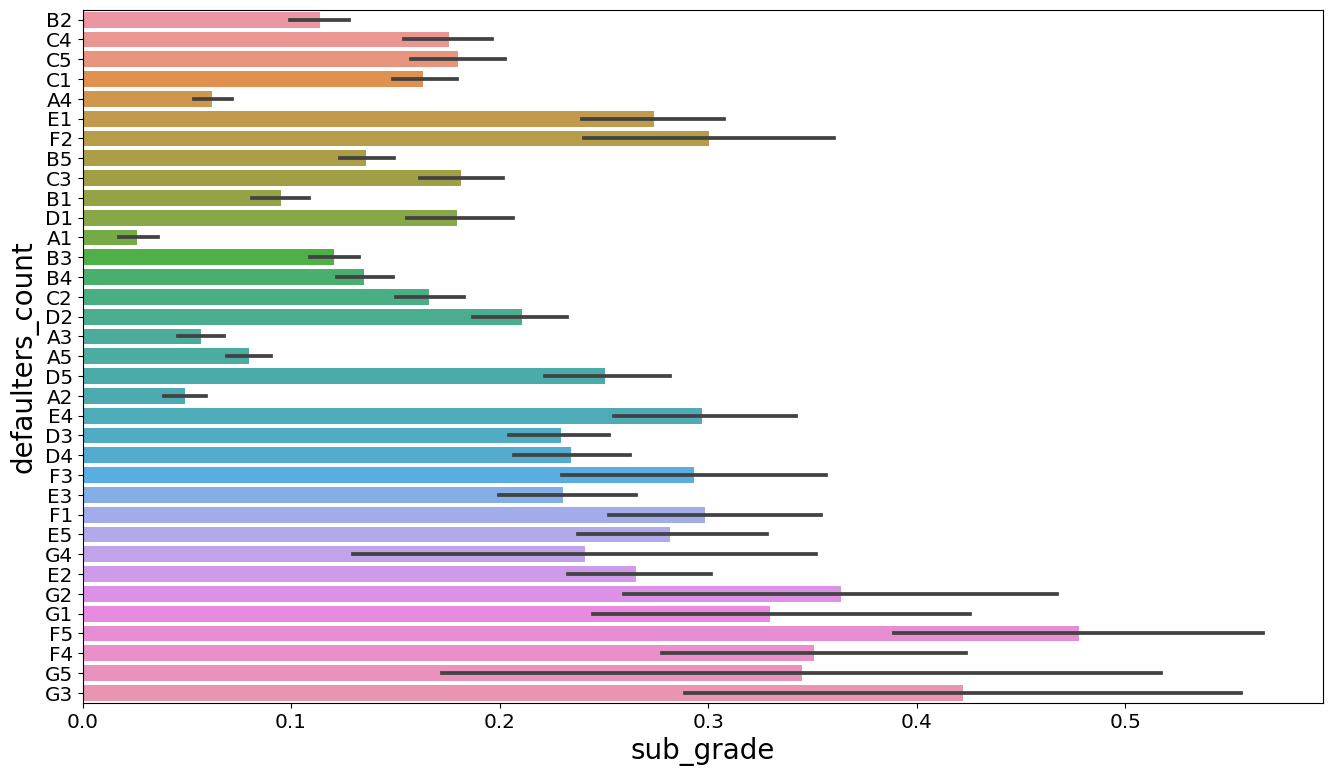

values count for home_ownership
RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: count, dtype: int64


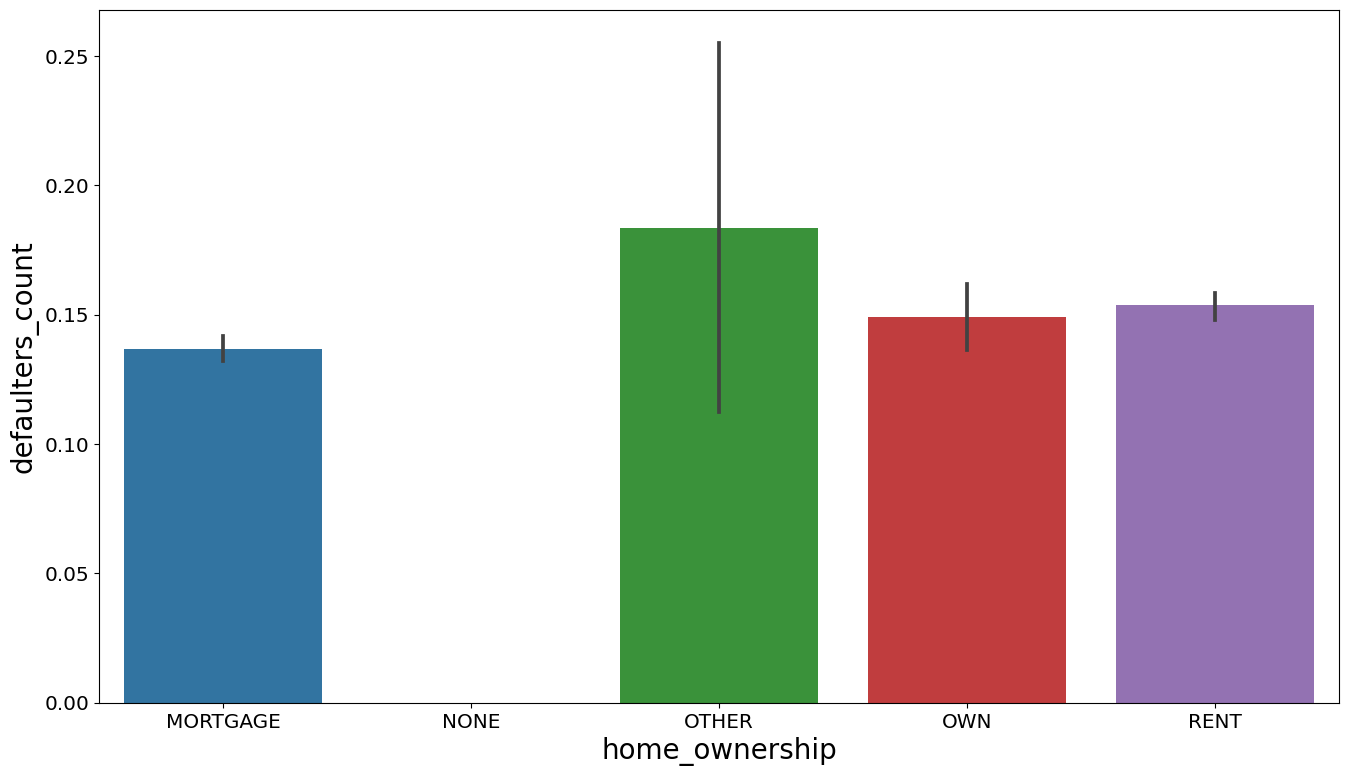

values count for verification_status
Not Verified       16694
Verified           12206
Source Verified     9677
Name: count, dtype: int64


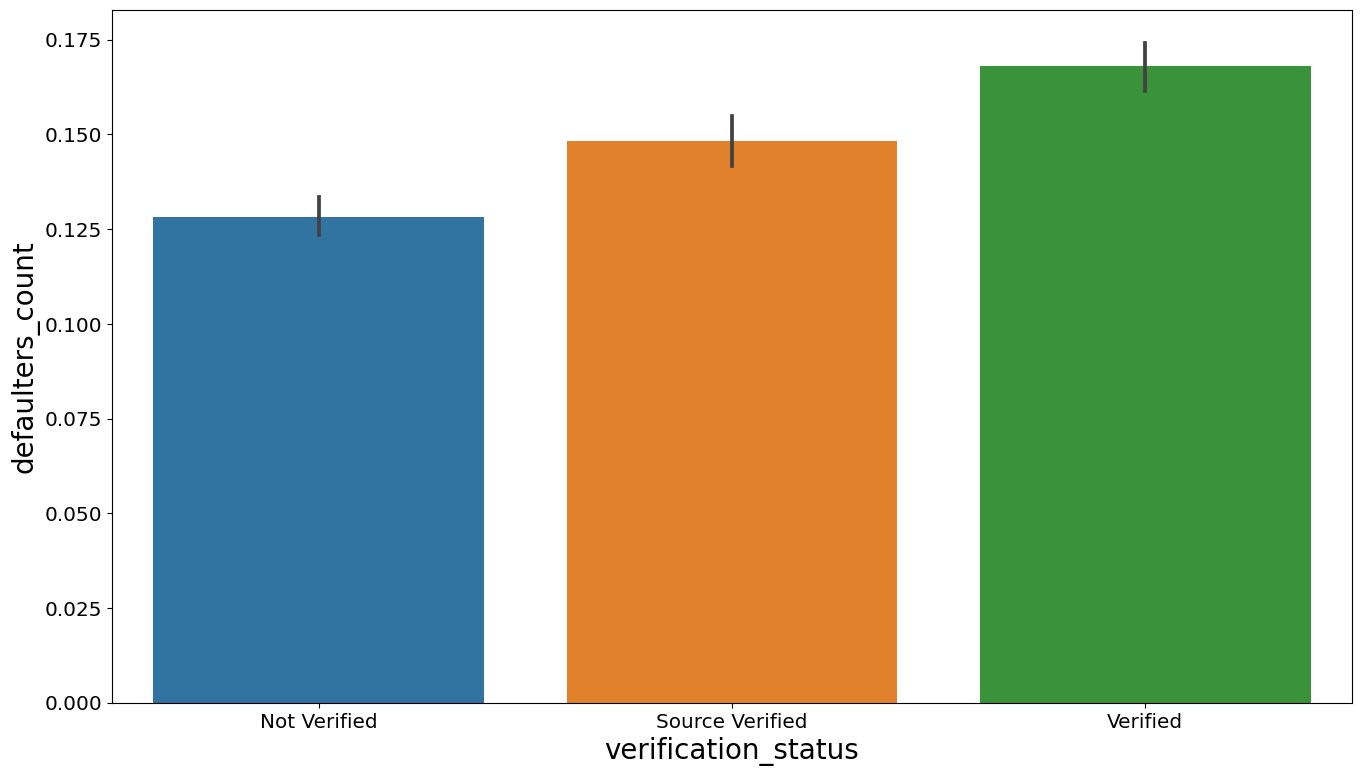

values count for purpose
debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: count, dtype: int64


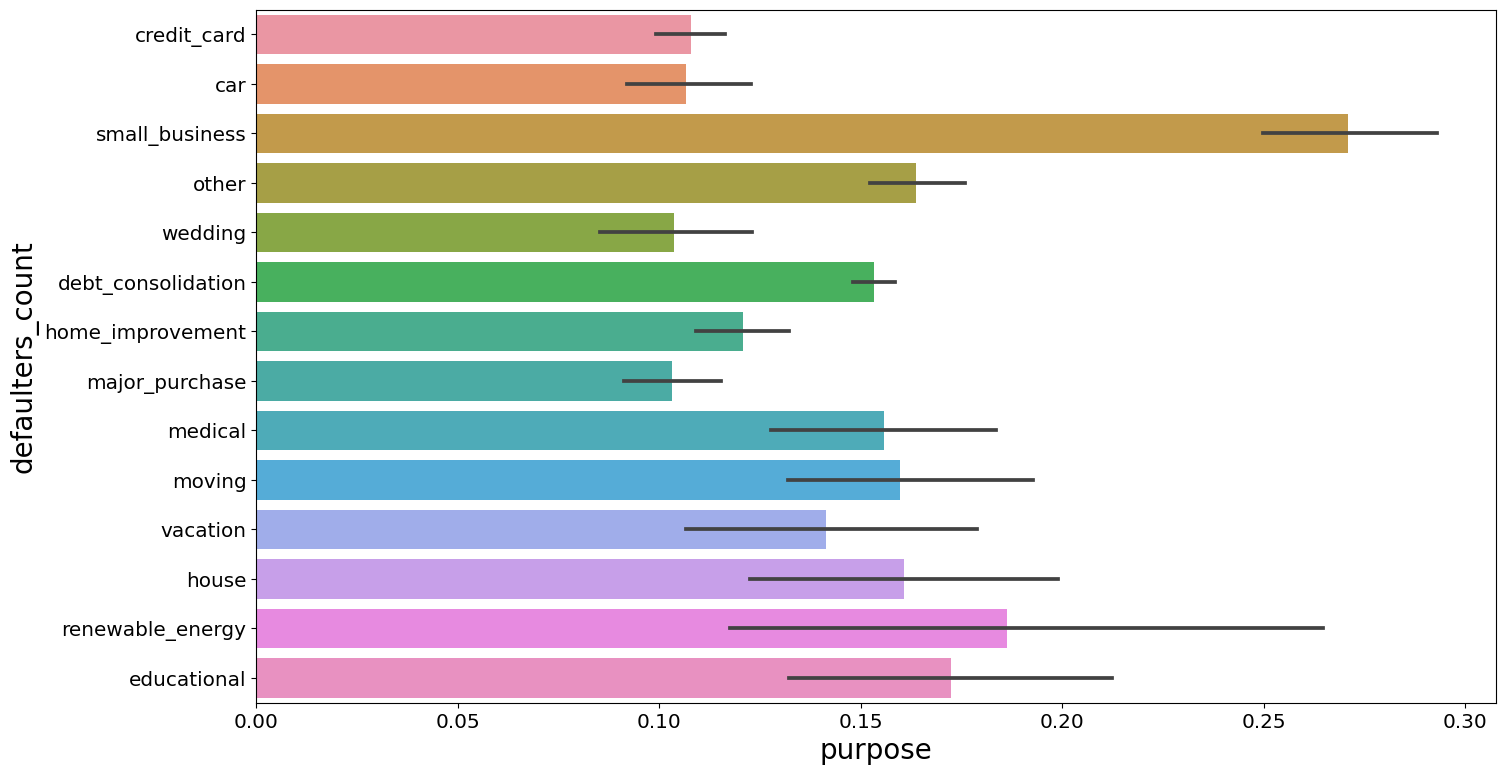

values count for addr_state
CA    6949
NY    3698
FL    2781
TX    2659
NJ    1790
IL    1478
PA    1468
VA    1369
GA    1359
MA    1297
OH    1178
MD    1023
AZ     849
WA     818
CO     766
NC     750
CT     726
MI     704
MO     670
MN     605
NV     479
SC     459
WI     440
AL     435
OR     435
LA     427
KY     311
OK     287
KS     255
UT     252
AR     235
DC     211
RI     194
NM     183
WV     172
NH     166
HI     166
DE     113
MT      83
WY      80
AK      78
SD      62
VT      53
MS      19
TN      17
IN       9
ID       6
IA       5
NE       5
ME       3
Name: count, dtype: int64


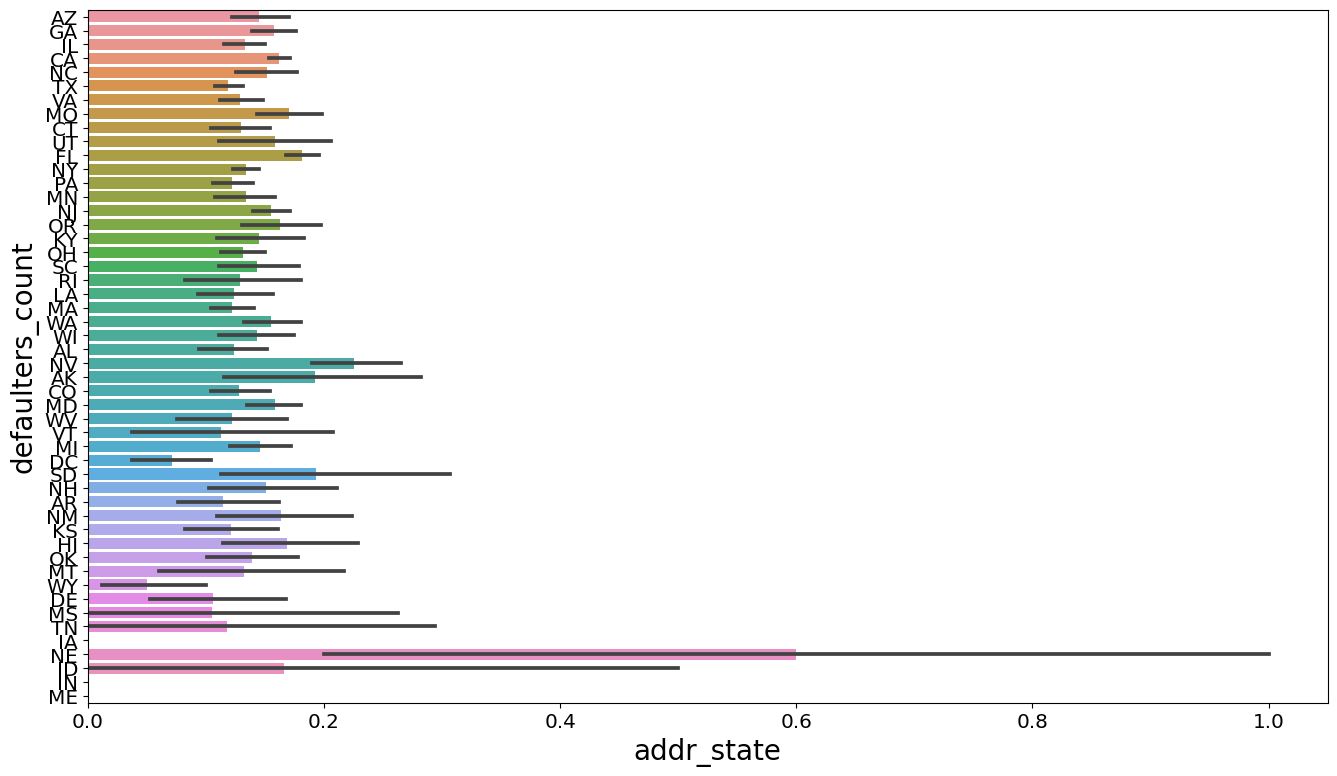

values count for emp_length
10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: count, dtype: int64


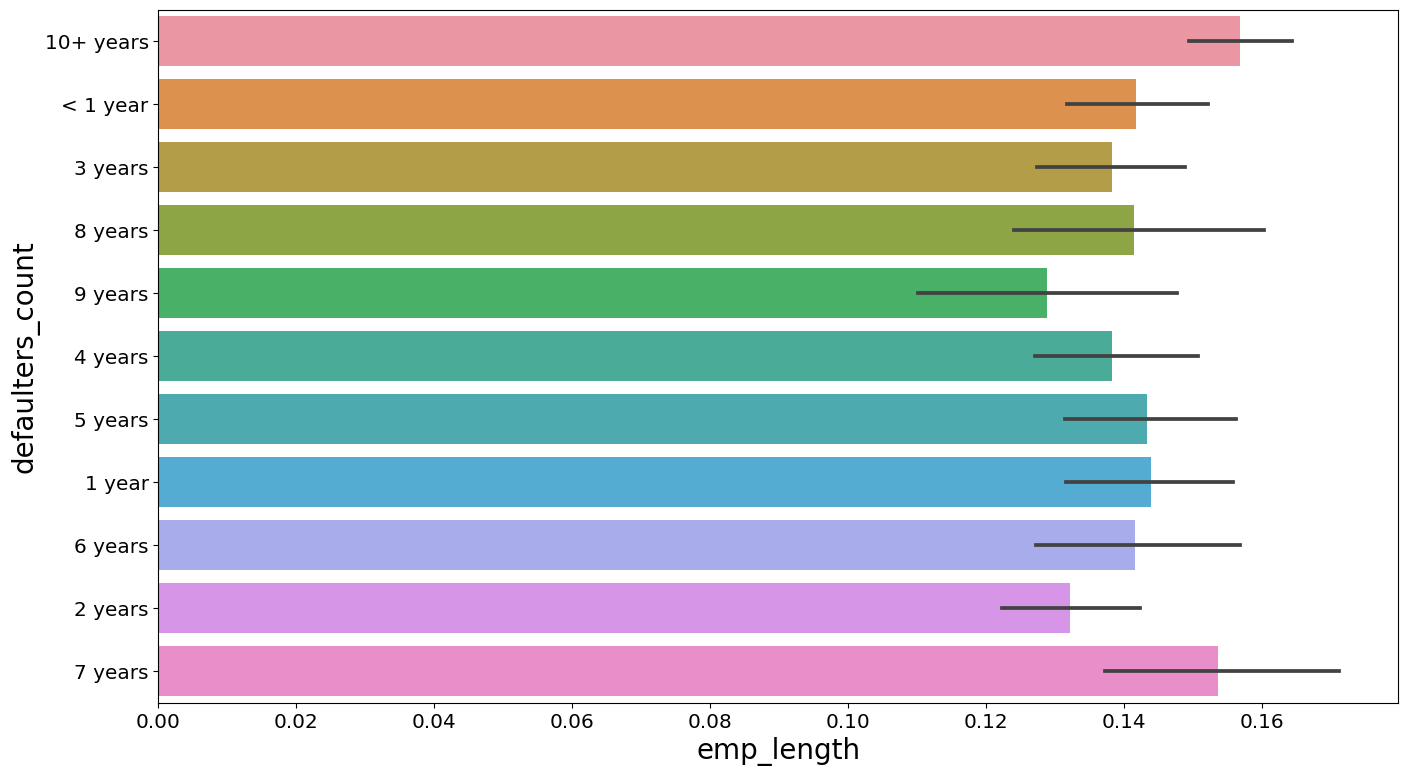

In [15]:
# gemerate plots for categorical data
for col_ in cat_cols:
    print('values count for', df[col_].value_counts())
    defaulters_bar_plot(col_, df)

list of sub categorical data that have the most defaulters ratio in its own segnment

In [53]:
# define pivot table initialization function
def create_pivot(col_):
    pivottable_ = pd.pivot_table(df, columns=['loan_status'], index=[col_], values=['all_count'], aggfunc='sum')
    pivottable_ = pivottable_.droplevel(0, axis=1)
    pivottable_['total_count'] = pivottable_['Charged Off'] + pivottable_['Fully Paid']
    pivottable_['defaulters_percent'] = pivottable_['Charged Off']/pivottable_['total_count']*100
    pivottable_.reset_index(inplace=True)
    pivottable_ = pivottable_.rename_axis(None, axis=1)   
    pivottable_.drop(index=pivottable_[pivottable_['total_count']<10].index, inplace=True)
    pivottable_.fillna(0, inplace=True)    
    return pivottable_

In [56]:
# define function
def defaulters_pivot_top_cat (list_cols):
# initialize variables
    df['all_count'] = 1
    new_df = pd.DataFrame()

    # anlysis
    for col_ in list_cols:
        pivottable_ = create_pivot(col_)
        name = f'df_{col_}'    
        pivottable_.iloc[:,0] = f'{col_}' + ' - ' + pivottable_.iloc[:,0] 
        pivottable_.rename(columns={col_: 'category'}, inplace=True)
        new_df = pd.concat([new_df, pivottable_], axis=0)
    new_df.sort_values(by='defaulters_percent', ascending=False, inplace=True)
    return new_df

In [57]:
# display top sub category
defaulters_pivot_top_cat(cat_cols).head(20).style.hide()

category,Charged Off,Fully Paid,total_count,defaulters_percent
sub_grade - F5,54.000000,59.000000,113.000000,47.787611
sub_grade - G3,19.000000,26.000000,45.000000,42.222222
sub_grade - G2,28.000000,49.000000,77.000000,36.363636
sub_grade - F4,53.000000,98.000000,151.000000,35.099338
sub_grade - G5,10.000000,19.000000,29.000000,34.482759
grade - G,101.000000,198.000000,299.000000,33.779264
sub_grade - G1,31.000000,63.000000,94.000000,32.978723
grade - F,319.000000,657.000000,976.000000,32.684426
sub_grade - F2,70.000000,163.000000,233.000000,30.042918
sub_grade - F1,91.000000,214.000000,305.000000,29.836066


Yashasvi please explain the graphs above in this markdown

Univariate Numeric Data

funded_amnt     618
int_rate        332
installment    4317
annual_inc     1253
dti            2219
revol_util      999
dtype: int64


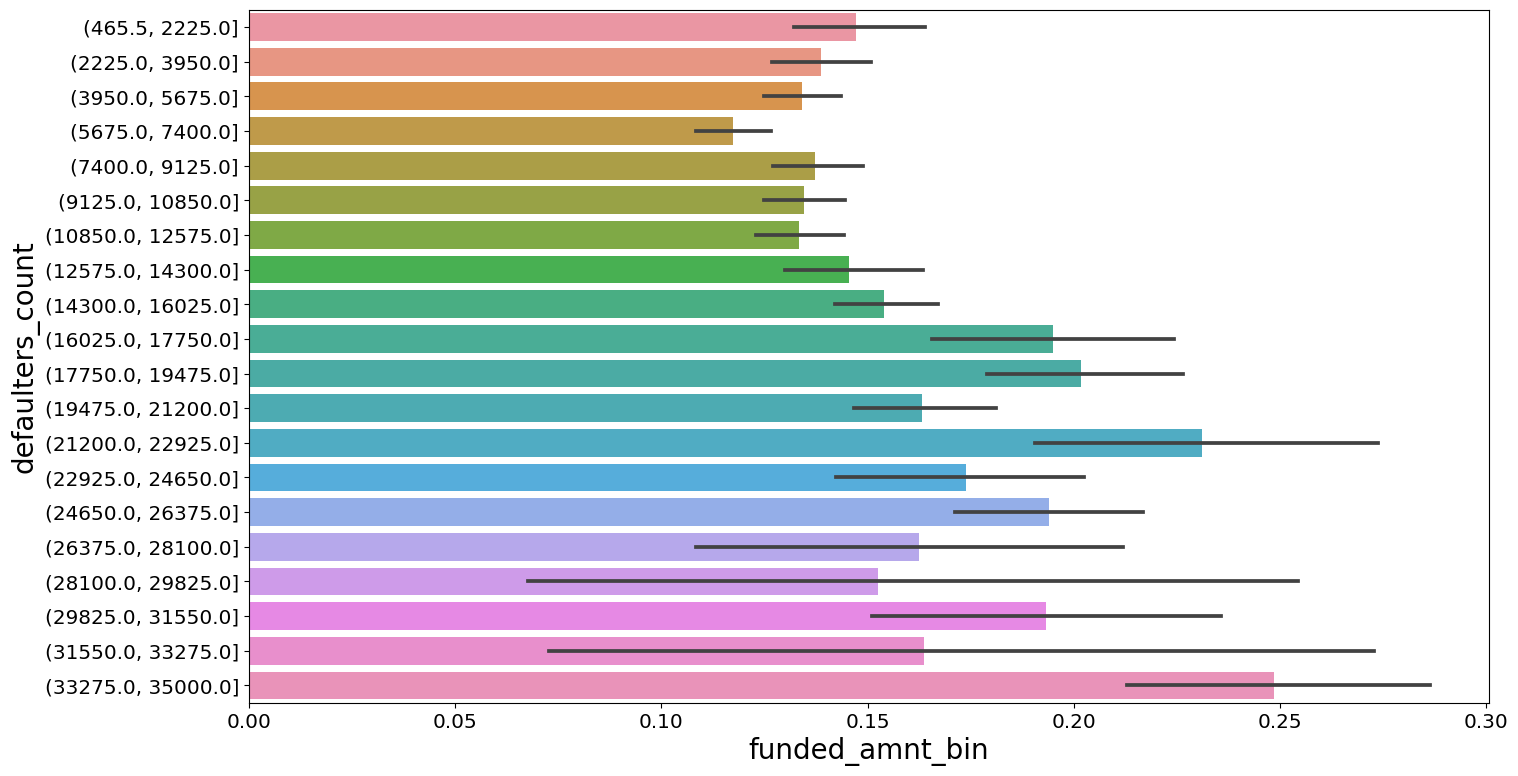

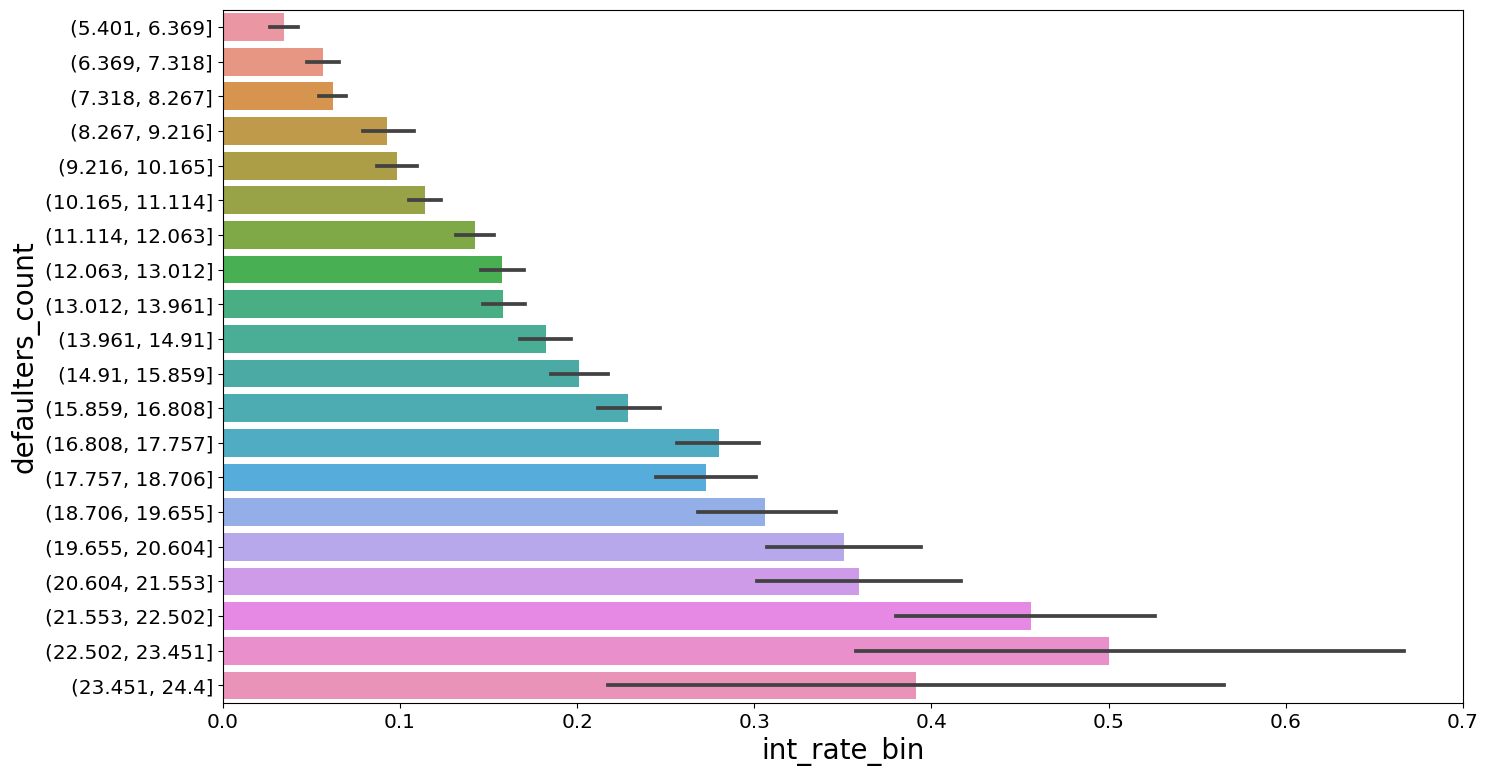

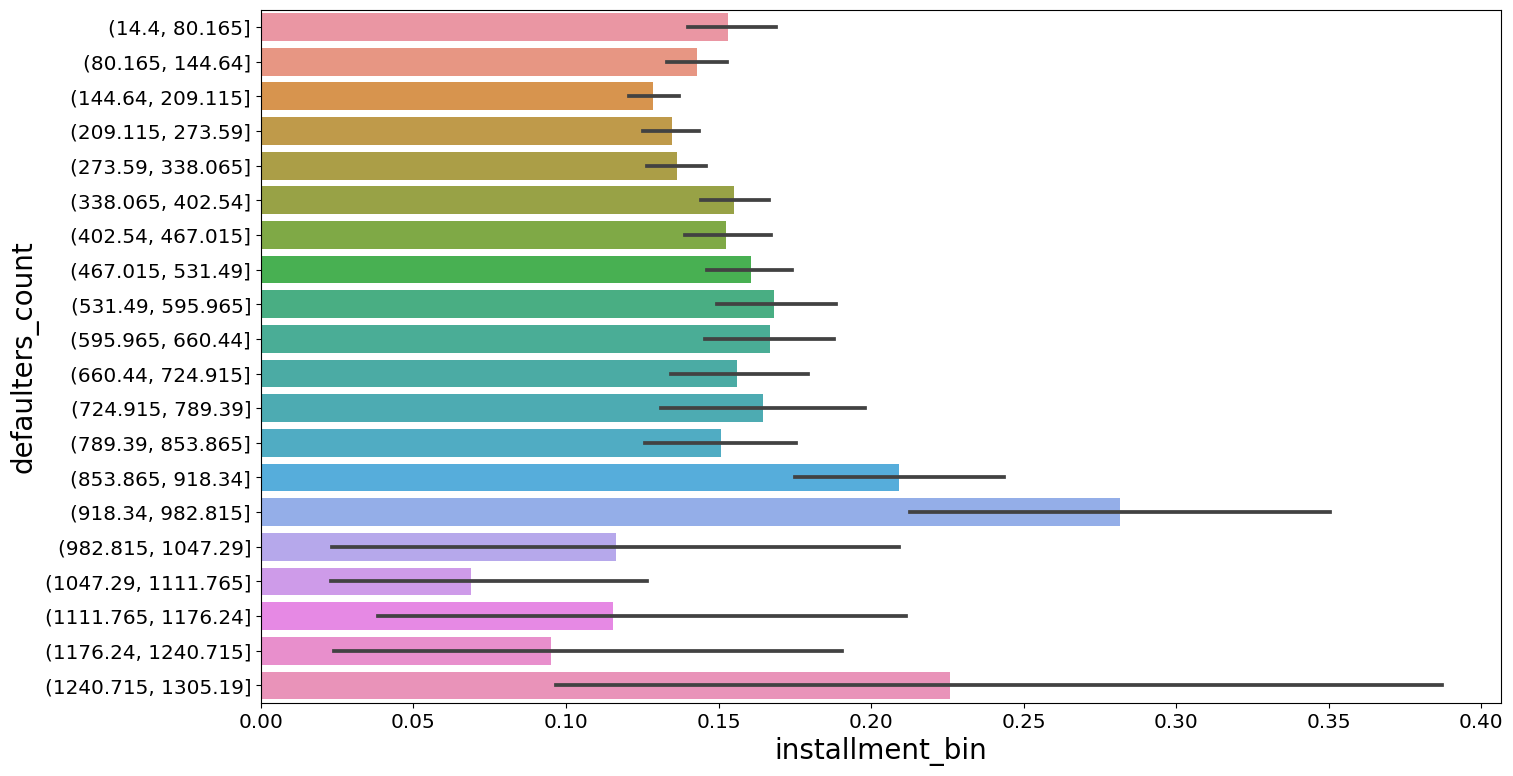

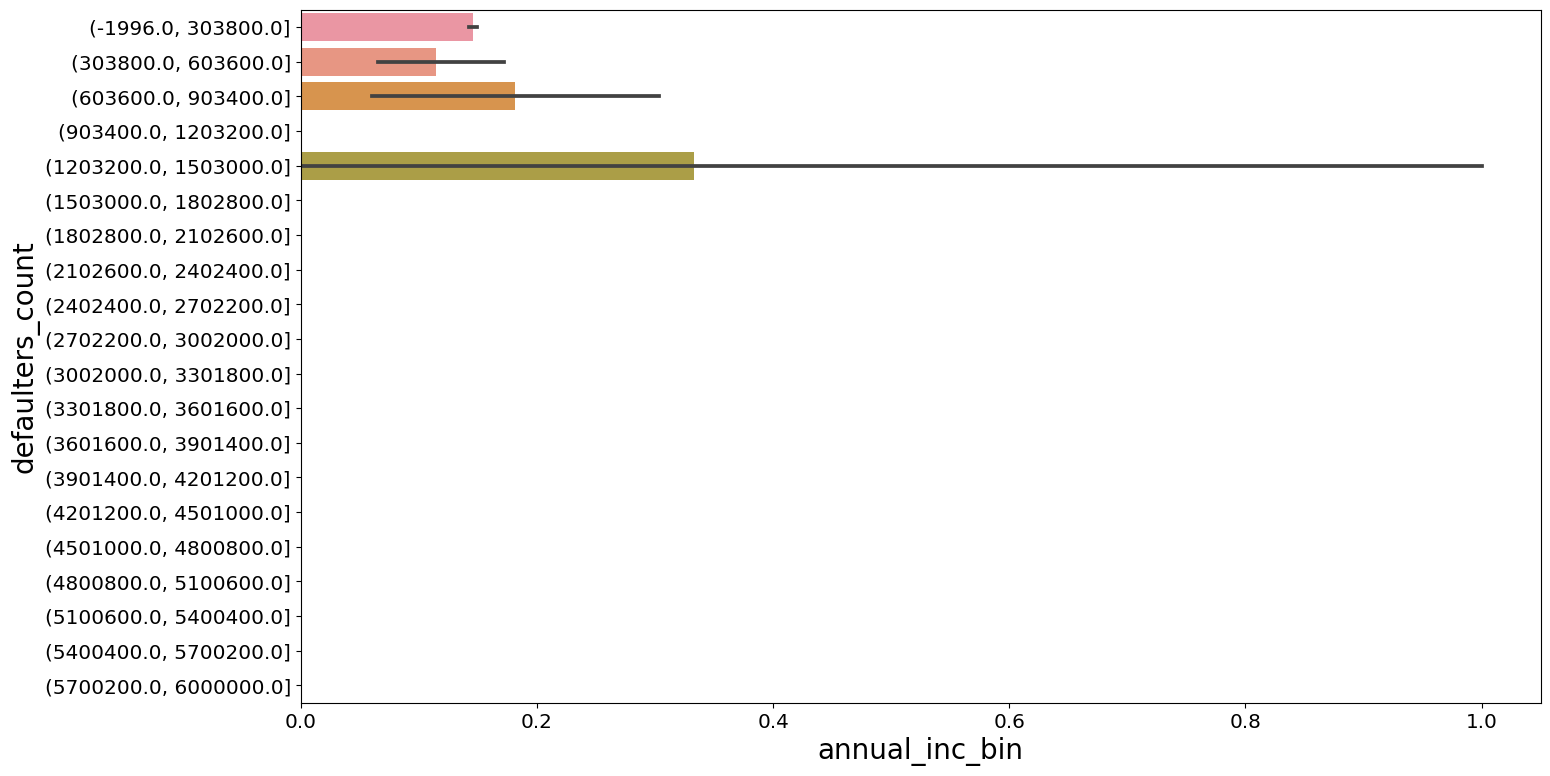

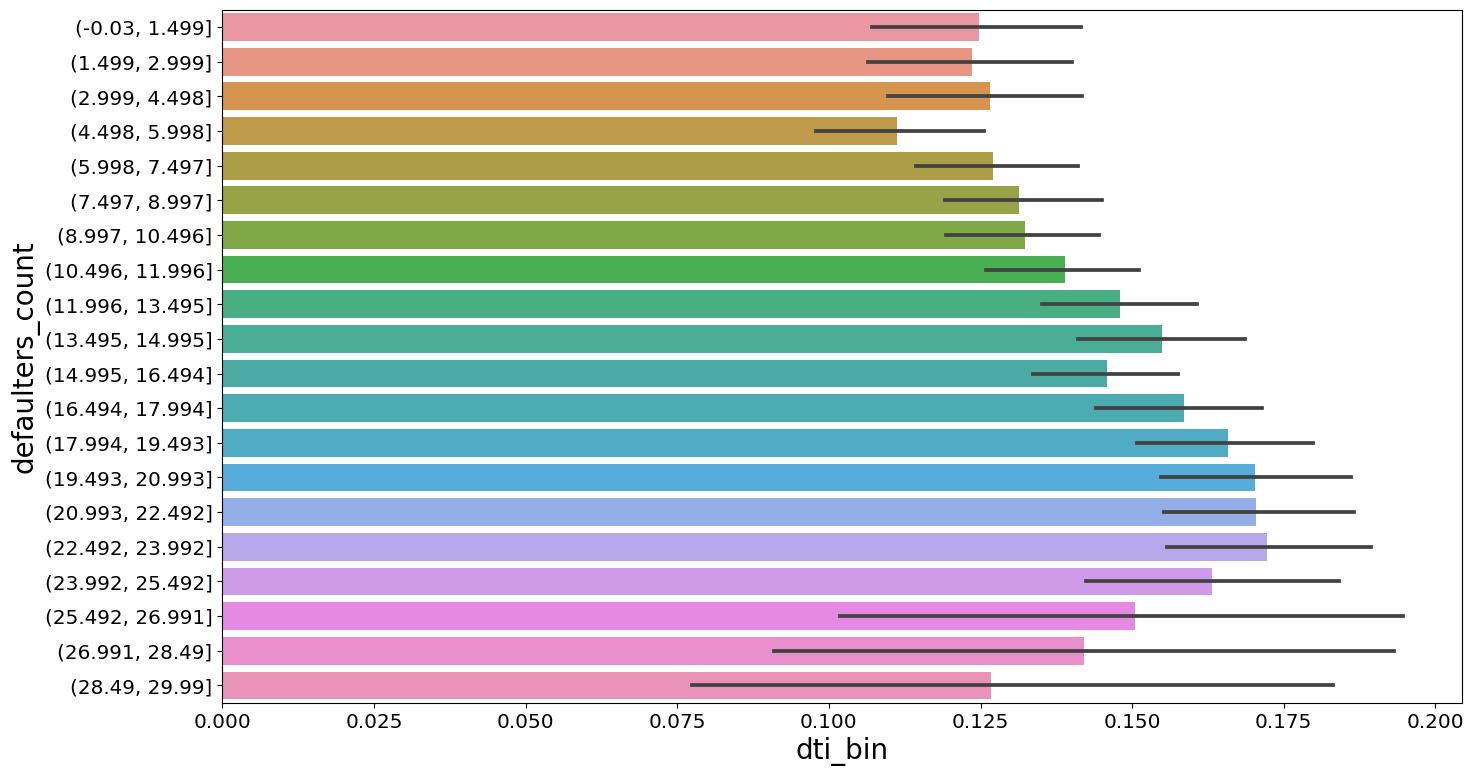

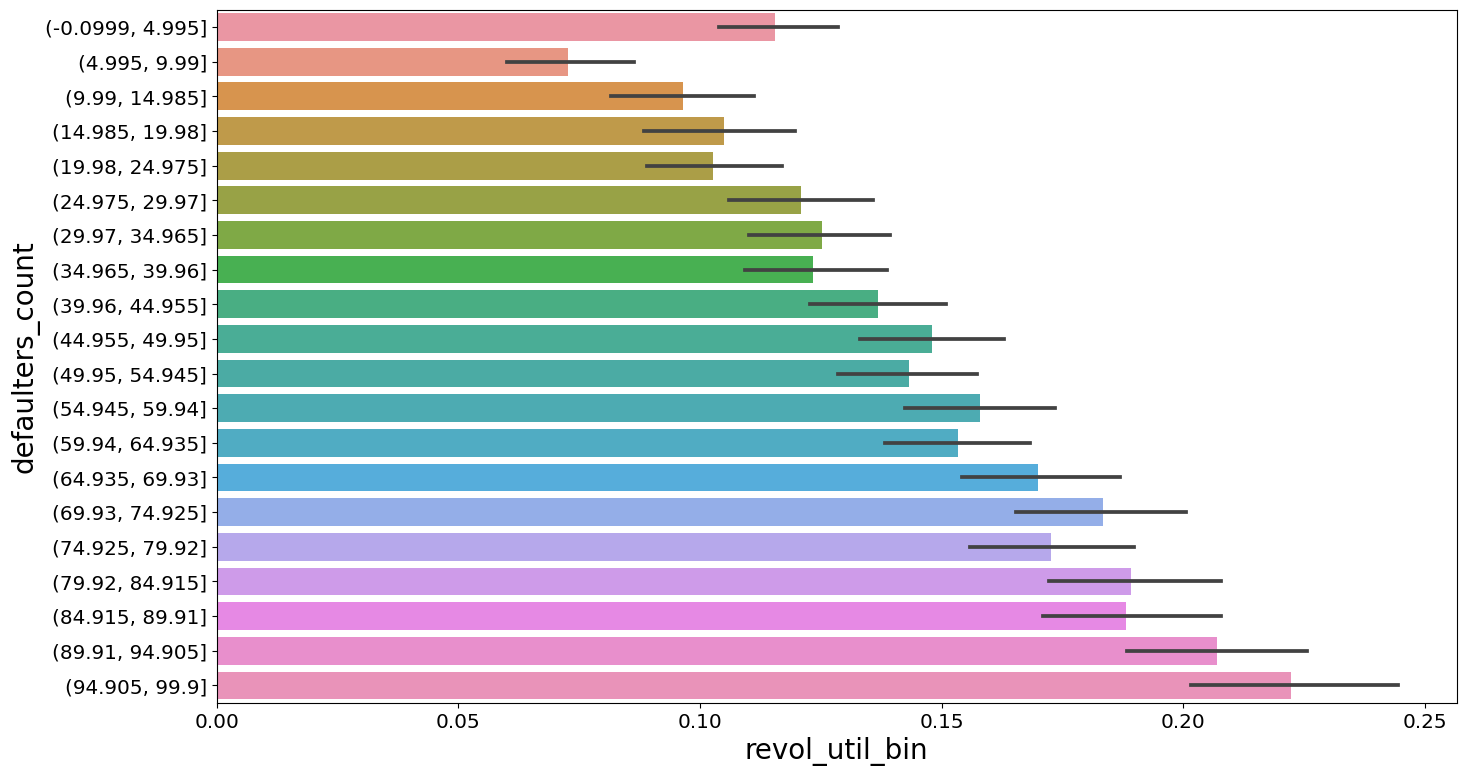

In [18]:
# count unique values of each numerical column data
defaulters_df = df[df['defaulters_count']==1]
count_unique = pd.Series({defaulters_df[x].name: defaulters_df[x].nunique() for x in num_cols})
print(count_unique)

# identify outliers
for col_ in num_cols:
    name = f'{col_}_bin'
    df[name] = pd.cut(np.array(df[col_]), bins=20)
    defaulters_bar_plot(name,df)

1440000.0
new_annual_inc_bin
(2564.0, 75800.0]         27117
(75800.0, 147600.0]        9725
(147600.0, 219400.0]       1261
(219400.0, 291200.0]        254
(291200.0, 363000.0]        108
(363000.0, 434800.0]         30
(434800.0, 506600.0]         17
(506600.0, 578400.0]         13
(578400.0, 650200.0]         10
(650200.0, 722000.0]          8
(722000.0, 793800.0]         11
(793800.0, 865600.0]          3
(865600.0, 937400.0]          5
(937400.0, 1009200.0]         1
(1009200.0, 1081000.0]        1
(1081000.0, 1152800.0]        0
(1152800.0, 1224600.0]        5
(1224600.0, 1296400.0]        1
(1296400.0, 1368200.0]        1
(1368200.0, 1440000.0]        1
Name: new_annual_inc_bin, dtype: int64


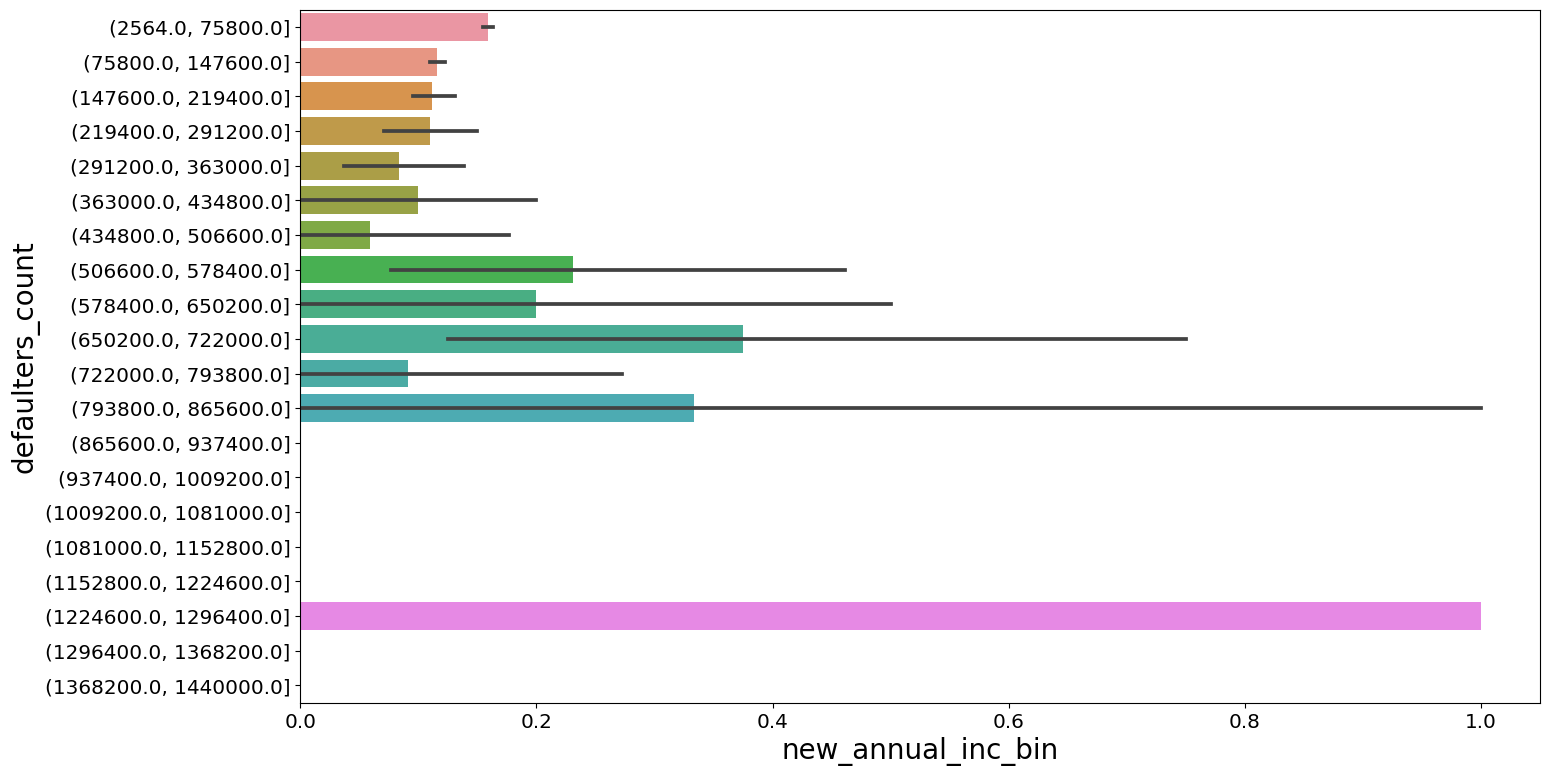

840000.0


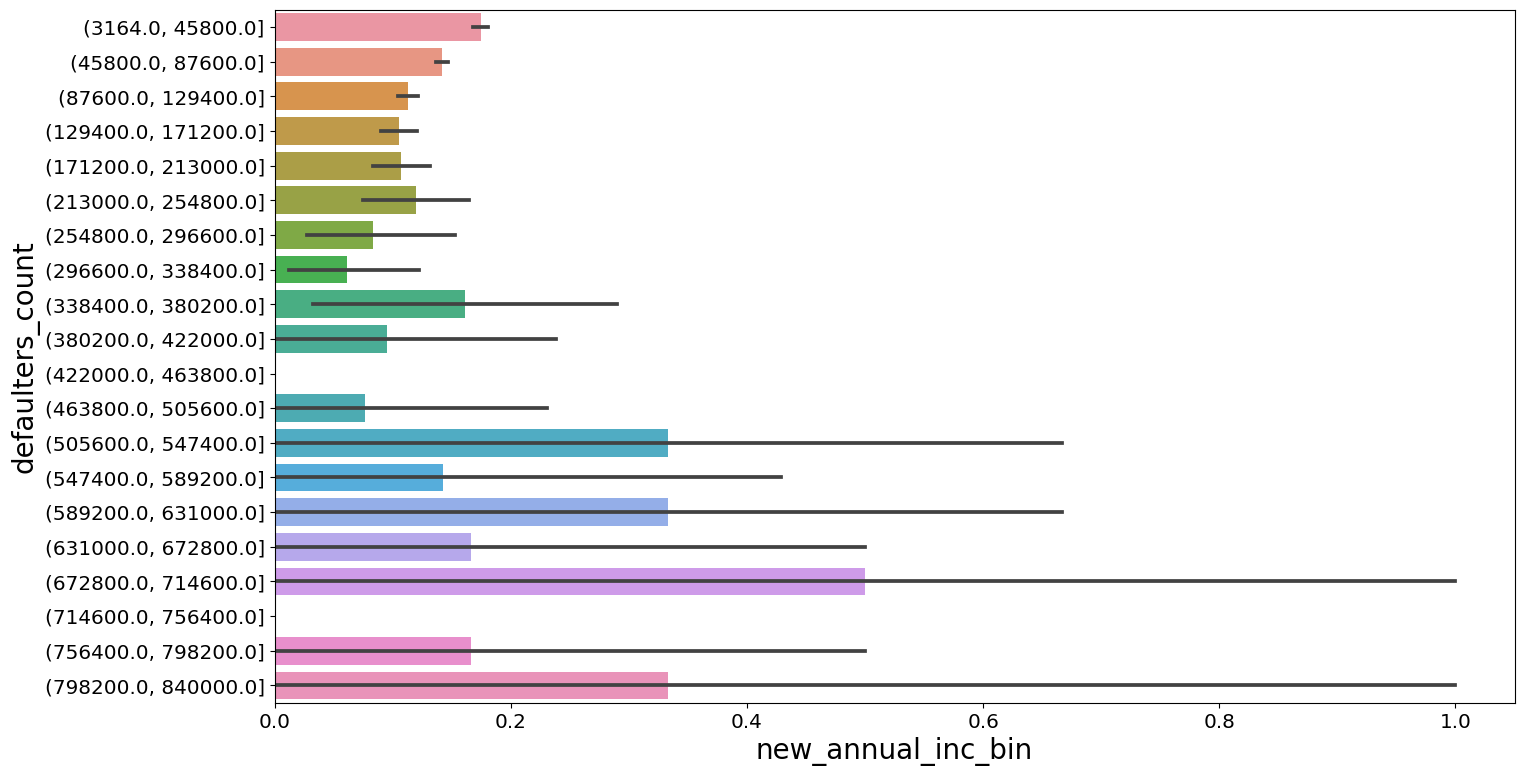

In [19]:
# remove outliers annual income first attempt
df['new_annual_inc'] = df[df['annual_inc'] <1503000]['annual_inc']
print(df['new_annual_inc'].max())
df['new_annual_inc_bin'] = pd.cut(np.array(df['new_annual_inc']), bins=20)
print(df.groupby('new_annual_inc_bin')['new_annual_inc_bin'].count())
defaulters_bar_plot('new_annual_inc_bin', df)

# remove outliers annual income second attempt
df['new_annual_inc'] = df[df['annual_inc'] <865600]['annual_inc']
print(df['new_annual_inc'].max())
df['new_annual_inc_bin'] = pd.cut(np.array(df['new_annual_inc']), bins=20)
df.groupby('new_annual_inc_bin')['new_annual_inc_bin'].count()
defaulters_bar_plot('new_annual_inc_bin', df)


list of most frequent defaulters' single values

In [54]:
# define function
def defaulters_pivot_top_num (list_cols, scale):
    df['all_count'] = 1

    for col_ in list_cols:

        # pivottable_ = pd.pivot_table(df, columns=['loan_status'], index=[col_], values=['all_count'], aggfunc='sum')
        # pivottable_ = pivottable_.droplevel(0, axis=1)
        # pivottable_['total_count'] = pivottable_['Charged Off'] + pivottable_['Fully Paid']
        # pivottable_['defaulters_percent'] = pivottable_['Charged Off']/pivottable_['total_count']*100
        # pivottable_.reset_index(inplace=True)
        # pivottable_ = pivottable_.rename_axis(None, axis=1)
        pivottable_ = create_pivot(col_)

        pivottable_.drop(index=pivottable_[pivottable_['total_count']<scale].index, inplace=True)
        pivottable_.sort_values(by='defaulters_percent', ascending=False, inplace=True)
        new_df = pivottable_.head(20)
        print(new_df)
        sns.barplot(new_df, y='defaulters_percent', x=col_, order=new_df.sort_values('defaulters_percent',ascending=False)[col_])
        plt.xlabel(col_, fontsize=20)
        plt.ylabel('defaulters_percent',fontsize=20)
        plt.show()

      funded_amnt  Charged Off  Fully Paid  total_count  defaulters_percent
272          7750         26.0        44.0         70.0           37.142857
571         15250         18.0        43.0         61.0           29.508197
803         21600         12.0        34.0         46.0           26.086957
1018        35000        126.0       373.0        499.0           25.250501
585         15600         13.0        39.0         52.0           25.000000
721         19200         11.0        34.0         45.0           24.444444
93           3250         15.0        47.0         62.0           24.193548
512         13750         11.0        37.0         48.0           22.916667
466         12600          9.0        33.0         42.0           21.428571
152          4750         15.0        57.0         72.0           20.833333
639         17000         42.0       162.0        204.0           20.588235
354          9800         13.0        53.0         66.0           19.696970
816         

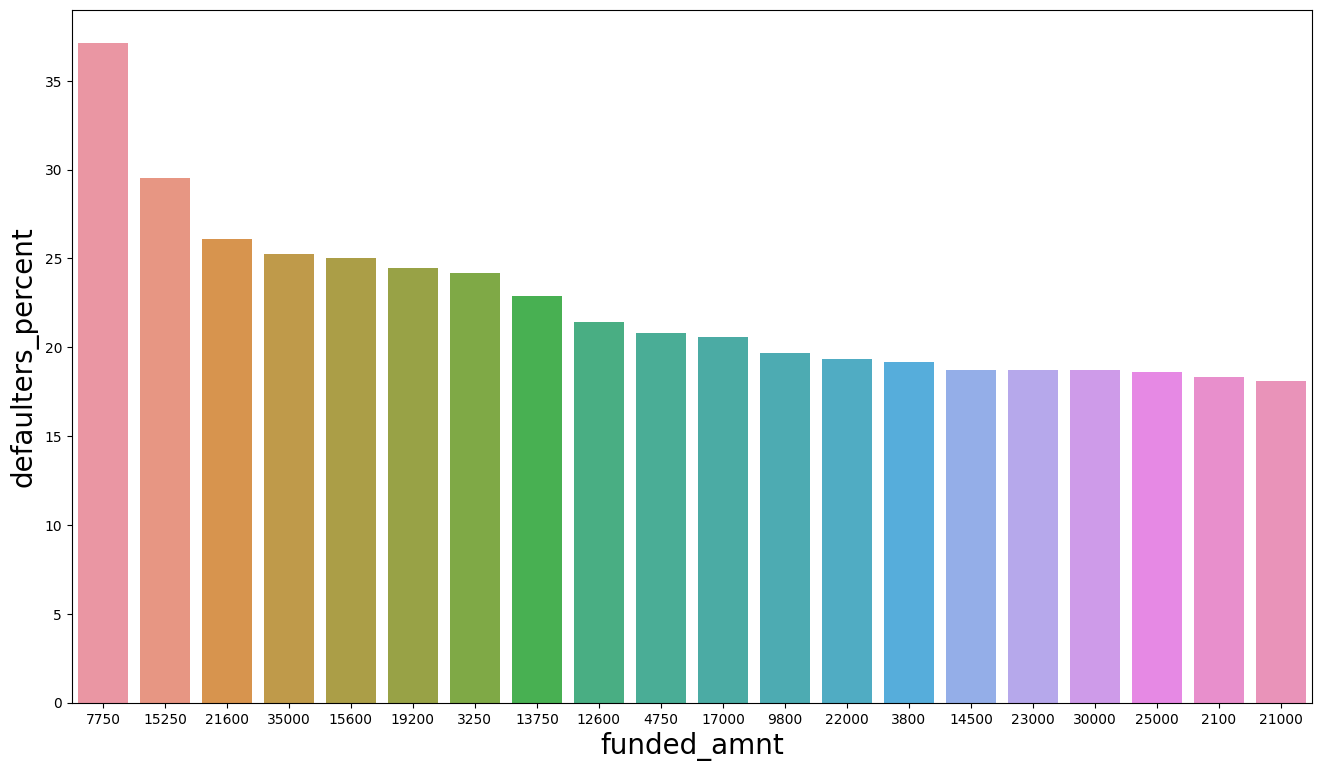

     int_rate  Charged Off  Fully Paid  total_count  defaulters_percent
340     20.89         29.0        27.0         56.0           51.785714
323     19.91         32.0        44.0         76.0           42.105263
330     20.30         31.0        46.0         77.0           40.259740
308     19.03         36.0        66.0        102.0           35.294118
276     17.49         59.0       114.0        173.0           34.104046
300     18.64         40.0        81.0        121.0           33.057851
335     20.62         15.0        31.0         46.0           32.608696
270     17.27         54.0       115.0        169.0           31.952663
329     20.25         22.0        47.0         69.0           31.884058
319     19.69         28.0        60.0         88.0           31.818182
260     16.89         57.0       125.0        182.0           31.318681
286     17.99         40.0        88.0        128.0           31.250000
316     19.42         28.0        63.0         91.0           30

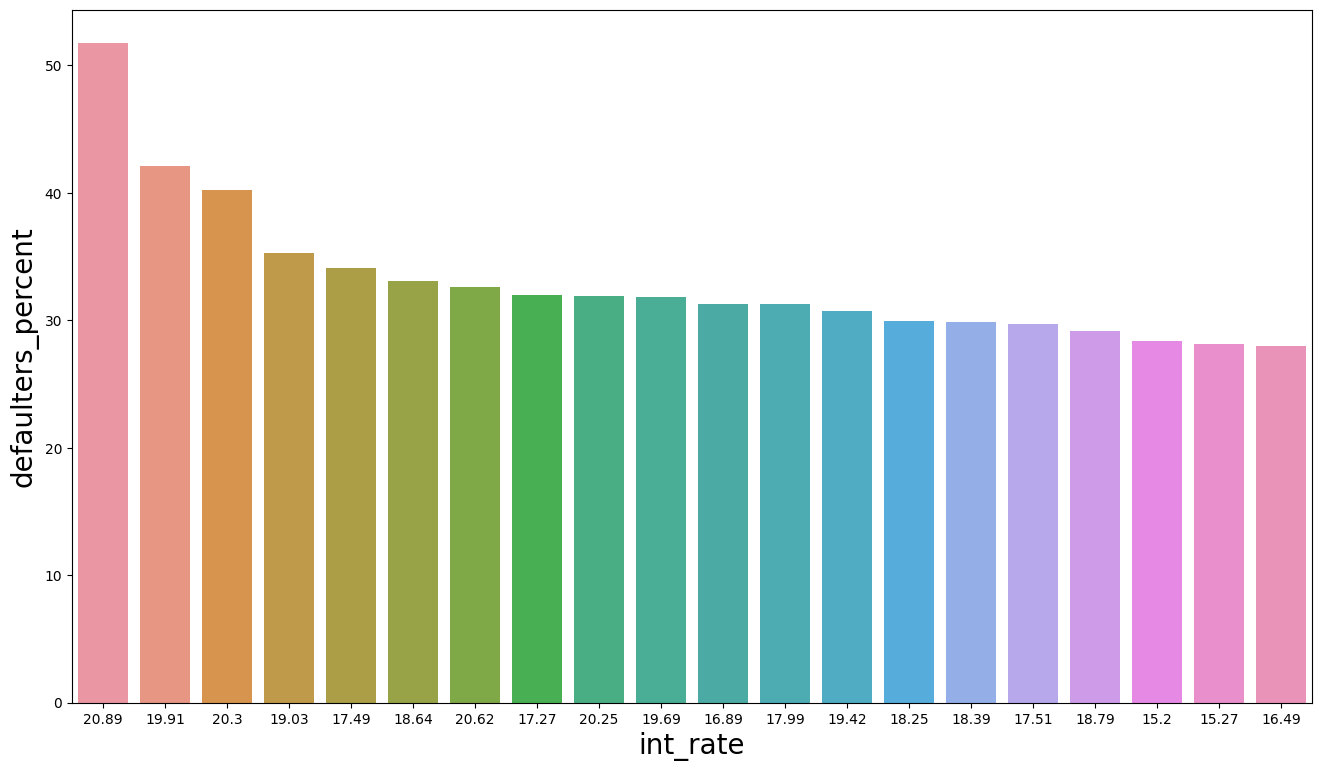

      installment  Charged Off  Fully Paid  total_count  defaulters_percent
8822       339.31          7.0        35.0         42.0           16.666667
8621       330.76          6.0        37.0         43.0           13.953488
9641       373.33          3.0        37.0         40.0            7.500000
8114       311.11          5.0        63.0         68.0            7.352941
8286       317.72          3.0        38.0         41.0            7.317073
9531       368.45          3.0        43.0         46.0            6.521739
4539       186.61          2.0        39.0         41.0            4.878049
7862       301.60          2.0        39.0         41.0            4.878049
9606       372.12          2.0        43.0         45.0            4.444444
3357       150.80          1.0        47.0         48.0            2.083333
8111       311.02          1.0        53.0         54.0            1.851852
4350       180.96          1.0        58.0         59.0            1.694915


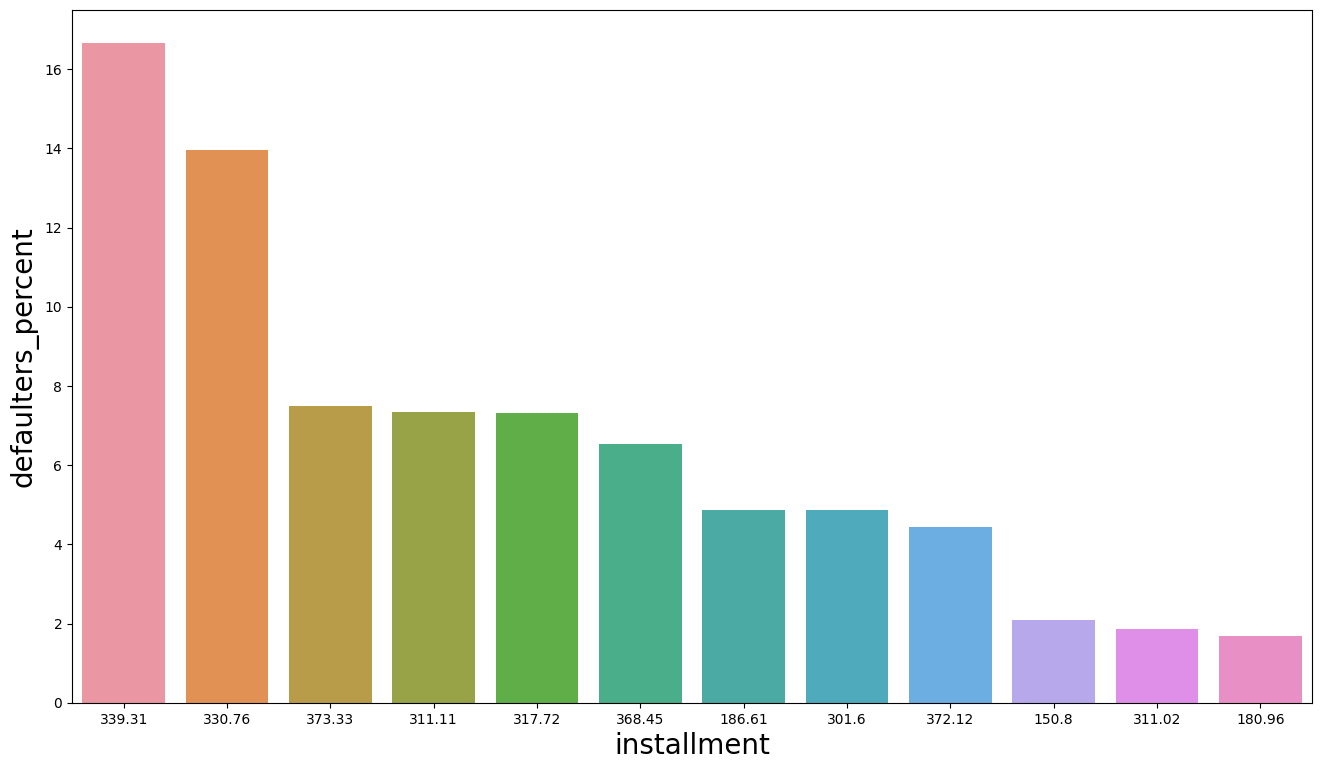

      annual_inc  Charged Off  Fully Paid  total_count  defaulters_percent
58       12000.0         24.0        63.0         87.0           27.586207
104      15000.0         17.0        48.0         65.0           26.153846
95       14400.0         24.0        70.0         94.0           25.531915
545      27600.0         15.0        45.0         60.0           25.000000
177      18000.0         34.0       103.0        137.0           24.817518
1542     43200.0         21.0        69.0         90.0           23.333333
2124     51600.0         10.0        33.0         43.0           23.255814
2196     52800.0         12.0        40.0         52.0           23.076923
462      26000.0         24.0        81.0        105.0           22.857143
1699     45600.0         18.0        61.0         79.0           22.784810
2044     50400.0         16.0        55.0         71.0           22.535211
246      20400.0          9.0        31.0         40.0           22.500000
1266     39000.0         

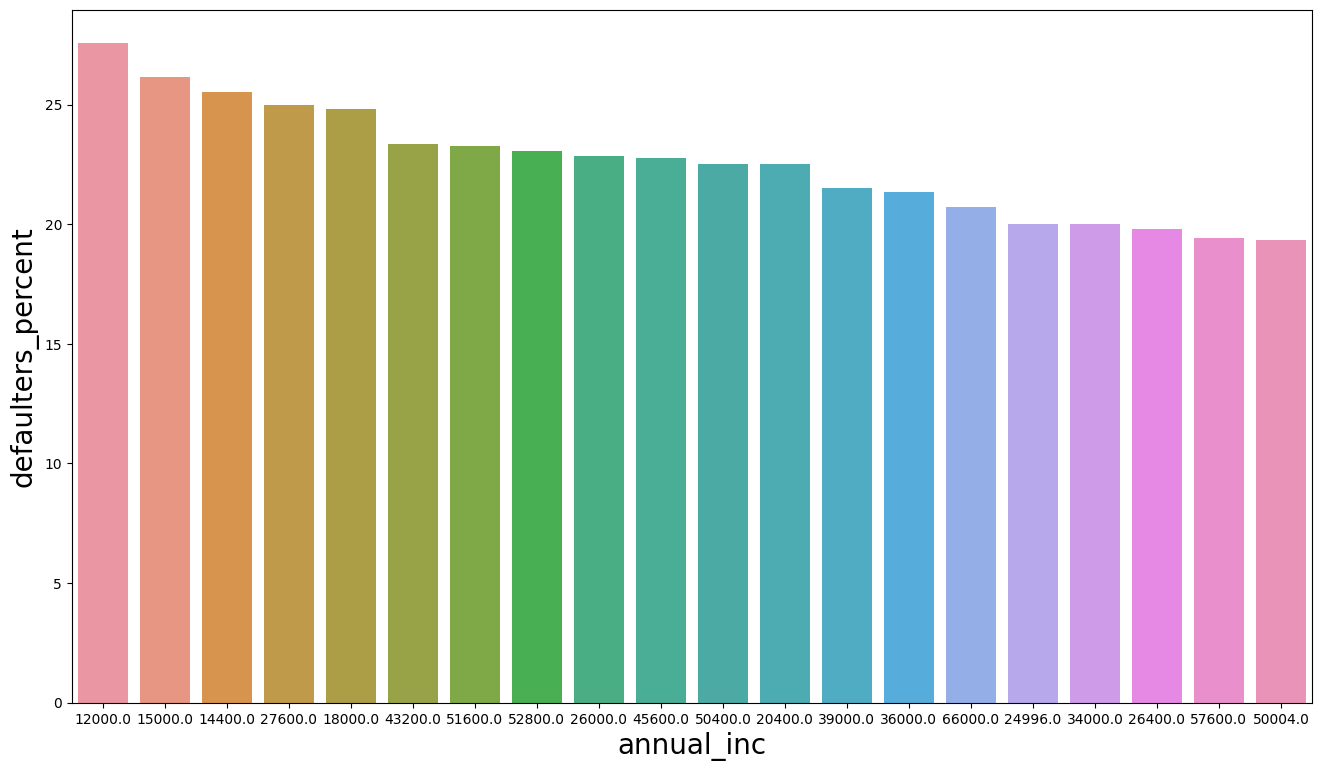

       dti  Charged Off  Fully Paid  total_count  defaulters_percent
1799  18.0         13.0        32.0         45.0           28.888889
0      0.0         29.0       149.0        178.0           16.292135
1199  12.0          5.0        41.0         46.0           10.869565


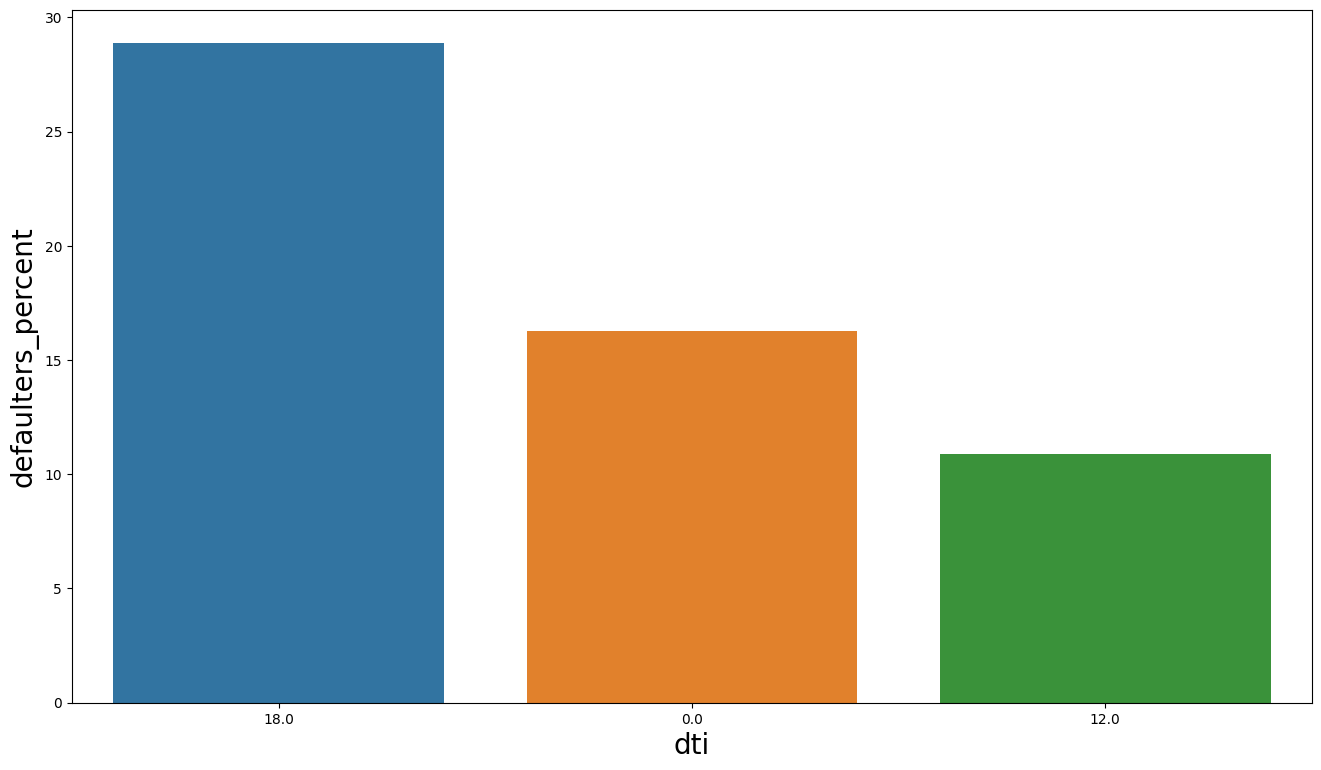

      revol_util  Charged Off  Fully Paid  total_count  defaulters_percent
718         63.7         15.0        28.0         43.0           34.883721
818         73.4         15.0        31.0         46.0           32.608696
891         80.6         14.0        30.0         44.0           31.818182
747         66.6         17.0        38.0         55.0           30.909091
888         80.3         13.0        30.0         43.0           30.232558
744         66.3         14.0        33.0         47.0           29.787234
1034        94.6         12.0        29.0         41.0           29.268293
801         71.7         13.0        33.0         46.0           28.260870
808         72.4         12.0        31.0         43.0           27.906977
902         81.6         12.0        31.0         43.0           27.906977
489         42.0         11.0        29.0         40.0           27.500000
1019        93.2         11.0        30.0         41.0           26.829268
737         65.6         

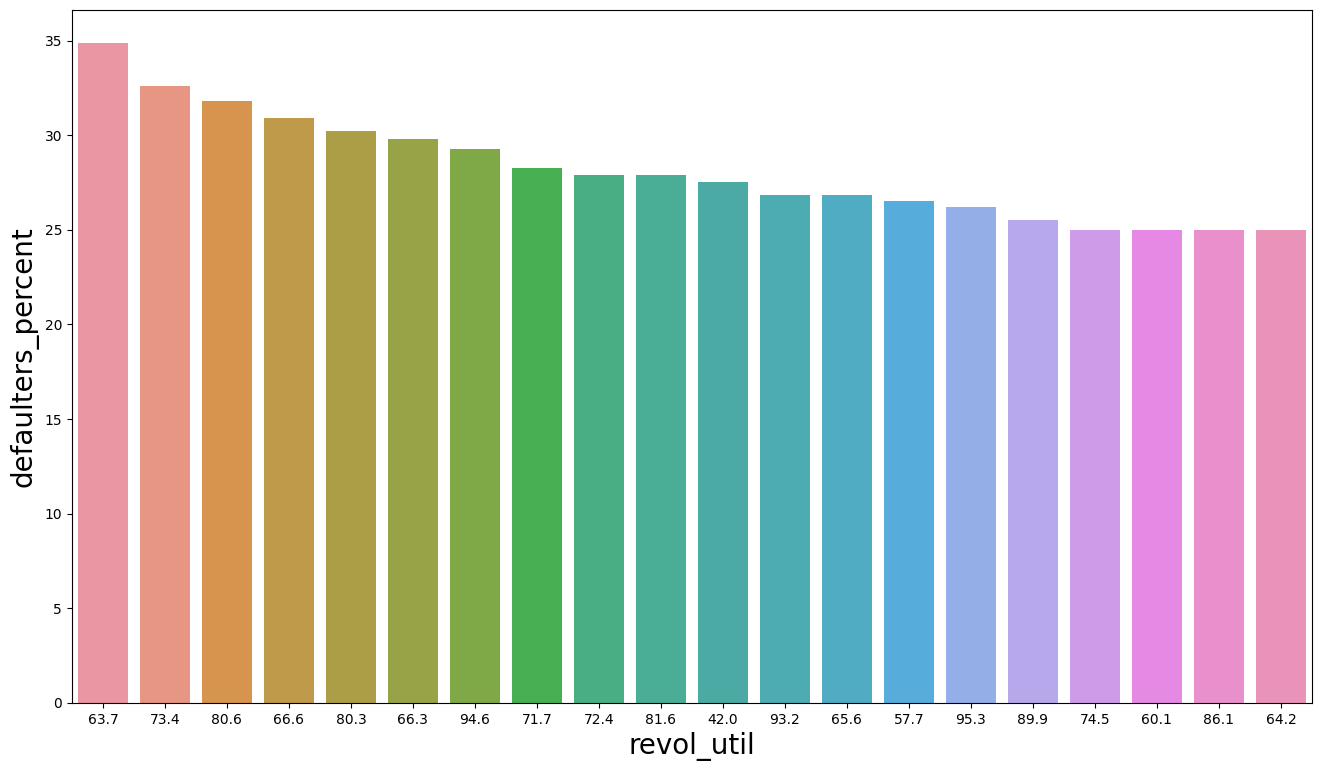

In [55]:
# execute function
defaulters_pivot_top_num(num_cols, 40)

Yashasvi: data pre-processing

In [ ]:
df.loan_status.value_counts()

In [ ]:
df.home_ownership.value_counts()

In [ ]:
df.verification_status.value_counts()

In [ ]:
cn = df.loan_status.value_counts()

In [ ]:
import matplotlib.pyplot as plt


plt.hist(df['loan_status'], bins=10)  
plt.xlabel('Values')
plt.show()